# 1.Сбор данных средствами SQL

```SQL
SELECT  
    aircrafts.model as model,  
    count(flights.departure_time) as flights_amount  
FROM  
    aircrafts  
INNER JOIN flights ON aircrafts.aircraft_code = flights.aircraft_code  
WHERE  
    cast(flights.departure_time as date) between '2018-09-01' and '2018-09-30'  
GROUP BY  
    model;  
```

```SQL
SELECT
    SUB.city,  
    avg(SUB.flights_count) as average_flights  
FROM  
    (SELECT  
        count(flights.flight_id) as flights_count,  
        extract(day from flights.arrival_time :: date) as day,  
        airports.city as city  
     FROM  
         airports  
     INNER JOIN flights on airports.airport_code = flights.arrival_airport  
     WHERE  
         flights.arrival_time :: date between '2018-08-01' and '2018-08-31'  
     GROUP BY  
         city,  
         day  
       ) as SUB  
GROUP BY  
    city  
```

# 2. Аналитика

Загрузим необходимые библиотеки и функции.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

Прочтем данные

In [2]:
models = pd.read_csv('/datasets/query_1.csv')
flights = pd.read_csv('/datasets/query_3.csv')
models

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


In [3]:
models.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


Пропусков нет, типы данных корректны.  
Т.к. в задании нужно построить график с общим кол-вом рейсов, добавим еще один столбец (среднее кол-во рейсов за день умножим на кол-во дней в сентябре).

In [4]:
flights['flights'] = (flights['average_flights'] * 30).astype(int)
flights

,city,average_flights,flights
0,Абакан,3.870968,116
1,Анадырь,1.000000,30
2,Анапа,2.161290,64
3,Архангельск,5.354839,160
4,Астрахань,2.451613,73
...,...,...,...
96,Чита,1.580645,47
97,Элиста,4.870968,146
98,Южно-Сахалинск,4.290323,128
99,Якутск,2.741935,82


In [5]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 3 columns):
city               101 non-null object
average_flights    101 non-null float64
flights            101 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.5+ KB


Пропусков нет, типы данных корректны.  
Сформируем ТОП-10 городов по количеству рейсов.

In [6]:
top_10 = flights.sort_values(by='average_flights', axis=0, ascending=False).head(10)
top_10

,city,average_flights,flights
43,Москва,129.774194,3893
70,Санкт-Петербург,31.161290,934
54,Новосибирск,17.322581,519
33,Красноярск,11.580645,347
20,Екатеринбург,11.322581,339
67,Ростов-на-Дону,10.193548,305
63,Пермь,10.129032,303
10,Брянск,10.000000,300
74,Сочи,9.612903,288
84,Ульяновск,9.580645,287


Построим график зависимости кол-ва рейсов от модели самолета.

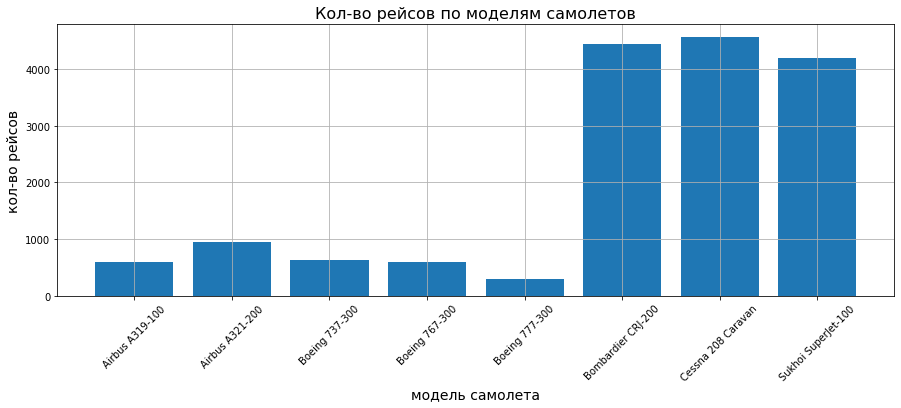

In [7]:
plt.figure(figsize=(15, 5))
plt.title('Кол-во рейсов по моделям самолетов', size=16)
plt.bar(models['model'], models['flights_amount'])
plt.grid()
plt.tick_params(axis ='x', labelrotation = 45)
plt.xlabel('модель самолета', size=14)
plt.ylabel('кол-во рейсов', size=14);

Видим тройку моделей, лидирующую с отрывом. Приятно, что в неё входит Superjet-100.  
Теперь построим график соответствия кол-ва рейсов и города прибытия.

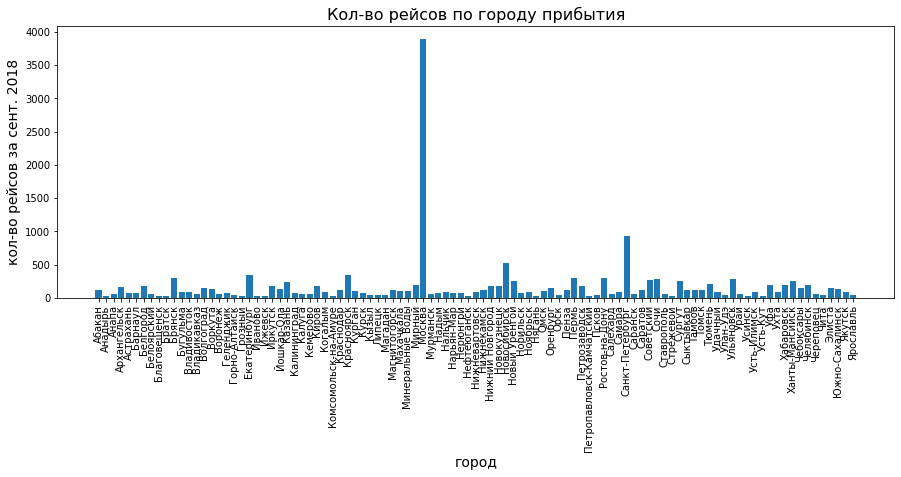

In [8]:
plt.figure(figsize=(15, 5))
plt.title('Кол-во рейсов по городу прибытия', size=16)
plt.bar(flights['city'], flights['flights'])
#plt.grid()
plt.tick_params(axis ='x', labelrotation = 90)
plt.xlabel('город', size=14)
plt.ylabel('кол-во рейсов за сент. 2018', size=14);

Видим один большой пик и два поменьше. В принципе и так ясно, что это за города, но уточним с помощью графика ТОП-10.

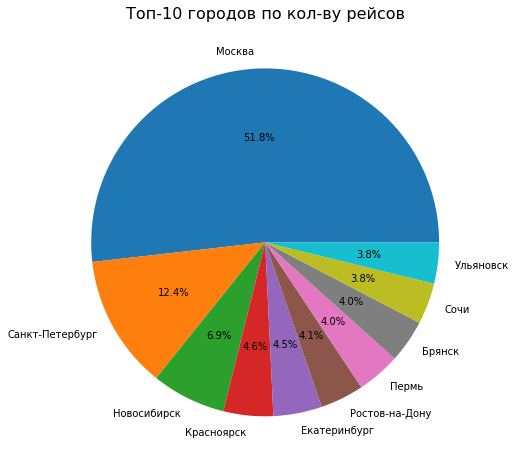

In [9]:
plt.figure(figsize=(8, 8))
plt.title('Топ-10 городов по кол-ву рейсов', size=16)
plt.pie(top_10['flights'], labels=top_10['city'], autopct='%1.1f%%');

Итак, чуть больше 50% занимает Москва, затем идут Питер и Новосиб, остальные в десятке распределены примерно одинаково.

# 3. Проверка гипотезы

Загрузим третий датасет и сразу заменим NaN-ы в столбце 'festival_week' на нули.

In [10]:
tickets = pd.read_csv('/datasets/query_last.csv')
tickets['festival_week'] = tickets['festival_week'].fillna(0)
tickets

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,0.0,NaN
3,33,51378,0.0,NaN
4,34,51492,0.0,NaN
5,35,51360,0.0,NaN
6,36,51386,36.0,Видфест
7,37,51670,0.0,NaN
8,38,51518,0.0,NaN
9,39,51623,0.0,NaN


Сформулируем нулевую гипотезу: во время фестивалей количество проданных билетов не изменяется.  Вообще говоря, данных слишком мало: всего 3 и 7 значений, но таково задание. Выборки разные по длине, поэтому используем scipy.stats.ttest_ind(). Уровень значимости установим в 5%.

Альтернативную гипотезу сформулируем так: «Средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время». Такая гипотеза является двусторонней, т.е неважно увеличивается или уменьшается спрос на билеты, главное, что он изменяется.  
Говорить о распределении парамера сложно при таком малом количестве значений. В таком случае можно применить U-критерий Манна-Уитни. Ограничения по его применению:  
1. В каждой из выборок должно быть не менее 3 значений признака. Допускается, чтобы в одной выборке было два значения, но во второй тогда не менее пяти.
2. В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10).  
  
Оба условия подходят под нашу задачу, однако документация библиотеки scipy однозначно рекомендует применять данный критерий только тогда, когда число наблюдений в каждой выборке больше 20.  
Будем использовать t-критерий Стьюдента для несвязанных совокупностей (а они не связаны, т.к данные взяты из разных временнЫх промежутков). Здесь ограничения на кол-во наблюдений не накладываются. Предположим, что количество проданных билетов стремится к нормальному распределению (распределение Стьюдента).

In [11]:
fest = tickets[tickets['festival_week']!=0]['ticket_amount']
no_fest = tickets[tickets['festival_week']==0]['ticket_amount']

print('cреднее кол-во проданных билетов во время фестиваля: ',int(fest.mean()))
print('cреднее кол-во проданных билетов, когда нет фестиваля: ',int(no_fest.mean()))

alpha = .05
results = st.ttest_ind(fest, no_fest)
#results = st.mannwhitneyu(fest, no_fest)
print('p-значение:', results.pvalue)

if (results.pvalue<alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cреднее кол-во проданных билетов во время фестиваля:  48662
cреднее кол-во проданных билетов, когда нет фестиваля:  51530
p-значение: 0.09688869045922928
Не получилось отвергнуть нулевую гипотезу


Как видим, нулевую гипотезу опровергнуть не удалось, с вероятностью около 10% разница случайна .  
Вывод - проведение фестивалей не оказывает существенного влияния на продажу билетов.  Но еще раз повторюсь: данных слишком мало, чтобы делать какие-либо серьезные заключения (например, U-критерий Манна-Уитни дает pvalue=0.34 и всё из-за одного единственного значения 43 568). На большей выборке можно оценить распределение, будет проще сделать выбор в пользу того или иного критерия, да и разные критерии должны будут показать более схожие значения.